<a href="https://colab.research.google.com/github/krishnakumarreddy007/64061_ktavva/blob/main/Assignment%2002%20Convolution%20Networks/Assignment_2_e_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AML Assignment 2 - Convolution Networks - Cats & Dogs dataset

Name: Krishna Kumar Tavva

Due Date: 14-Jul-2024

Load all the required libraries

In [ ]:
!pip install kaggle

In [ ]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import zipfile
import io
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from io import BytesIO
from zipfile import ZipFile

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tkkreddy","key":"a12d359326e4b61bac0e5612cdbf7bf9"}'}

**Create a Keggle folder**

In [ ]:
!mkdir ~/.kaggle

# Copy the keggle json to folder created
!cp kaggle.json ~/.kaggle/

# Permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

# List all the datasets in Kaggle
! kaggle datasets list

ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset                     📚 Students Performance Dataset 📚                    66KB  2024-06-12 23:09:20          12516        263  1.0              
nelgiriyewithana/most-streamed-spotify-songs-2024               Most Streamed Spotify Songs 2024                   496KB  2024-06-15 18:50:51           9553        201  1.0              
ihelon/coffee-sales                                             Coffee Sales                                        10KB  2024-07-03 20:04:43           2237         49  1.0              
dataanalyst001/population-of-all-us-cities-2024                 P

Download the Dogs and Cats Dataset

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:04<00:00, 252MB/s]
100% 812M/812M [00:04<00:00, 176MB/s]


Unzipping the data

In [ ]:
!unzip -qq dogs-vs-cats.zip

Unzipping the training data

In [ ]:
!unzip -qq train.zip

 **1.Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?**

Dividing the dataset into three sample sets: training = 1000, validation = 500, and test = 500

In [ ]:
import os, shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

make_subset("train", start_index=0, end_index=500)
make_subset("validation", start_index=500, end_index=750)
make_subset("test", start_index=750, end_index=1000)


Data Pre-Processing - Using image_dataset_from_directory to read images and functions

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 1000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


Viewing the shape of the images



In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Model - 1 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers : Instantiating a small convnet for dogs vs. cats classification

In [ ]:
#Building the model
#Instantiating a small convnet for dogs vs. cats classification
#*Model - 1 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers*

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs=inputs, outputs=outputs)

Summary

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

Model 1: Training

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model1.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting the Model

Model_1 = model.fit(
          train_dataset,
          epochs=30,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/30
32/32 [==============================] - 10s 278ms/step - loss: 0.7001 - accuracy: 0.5020 - val_loss: 0.6925 - val_accuracy: 0.5260
Epoch 2/30
32/32 [==============================] - 9s 269ms/step - loss: 0.6933 - accuracy: 0.4950 - val_loss: 0.6926 - val_accuracy: 0.5540
Epoch 3/30
32/32 [==============================] - 9s 269ms/step - loss: 0.6886 - accuracy: 0.5600 - val_loss: 0.9839 - val_accuracy: 0.5000
Epoch 4/30
32/32 [==============================] - 9s 268ms/step - loss: 0.6927 - accuracy: 0.5730 - val_loss: 0.6947 - val_accuracy: 0.5240
Epoch 5/30
32/32 [==============================] - 9s 272ms/step - loss: 0.6630 - accuracy: 0.6090 - val_loss: 0.6607 - val_accuracy: 0.6360
Epoch 6/30
32/32 [==============================] - 8s 259ms/step - loss: 0.6375 - accuracy: 0.6500 - val_loss: 0.6665 - val_accuracy: 0.6380
Epoch 7/30
32/32 [==============================] - 8s 259ms/step - loss: 0.5851 - accuracy: 0.7080 - val_loss: 0.6935 - val_accuracy: 0.5880
Epoch

Plotting Training and Validation Accuracy

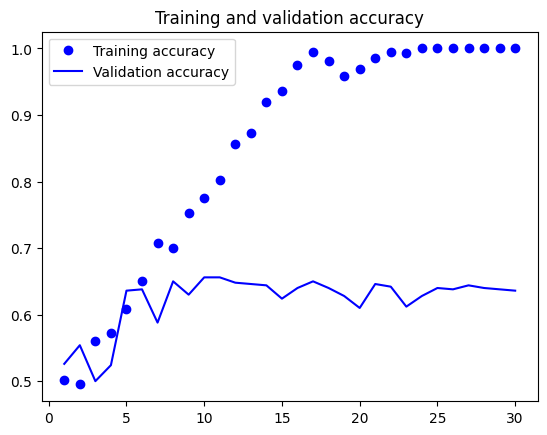

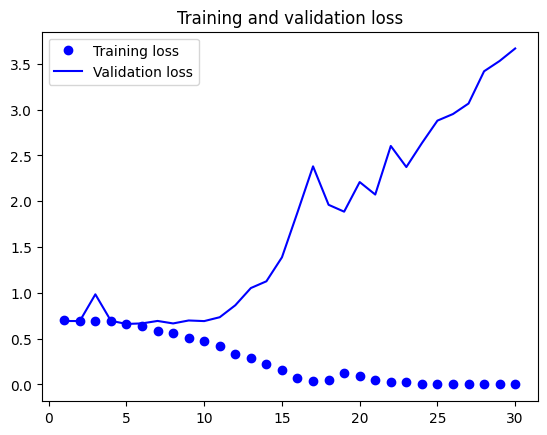

In [ ]:
import matplotlib.pyplot as plt

accuracy = Model_1.history["accuracy"]
val_accuracy = Model_1.history["val_accuracy"]
loss = Model_1.history["loss"]
val_loss = Model_1.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the performance of Model 1 on the test set

In [ ]:
test_model = keras.models.load_model("model1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

16/16 [==============================] - 1s 58ms/step - loss: 0.6765 - accuracy: 0.5980
Loss: 0.676
Accuracy: 0.598


Using Measures to Avoid Overfitting

Data Augmentation

In [ ]:
# To deprecate warnings that are making the output look clumsy

import logging

logging.getLogger('tensorflow').disabled = True

Using few of the techniques such as random flip, random zoom, random rotation so as to create augmented versions of the image

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

Looking at the augmented images

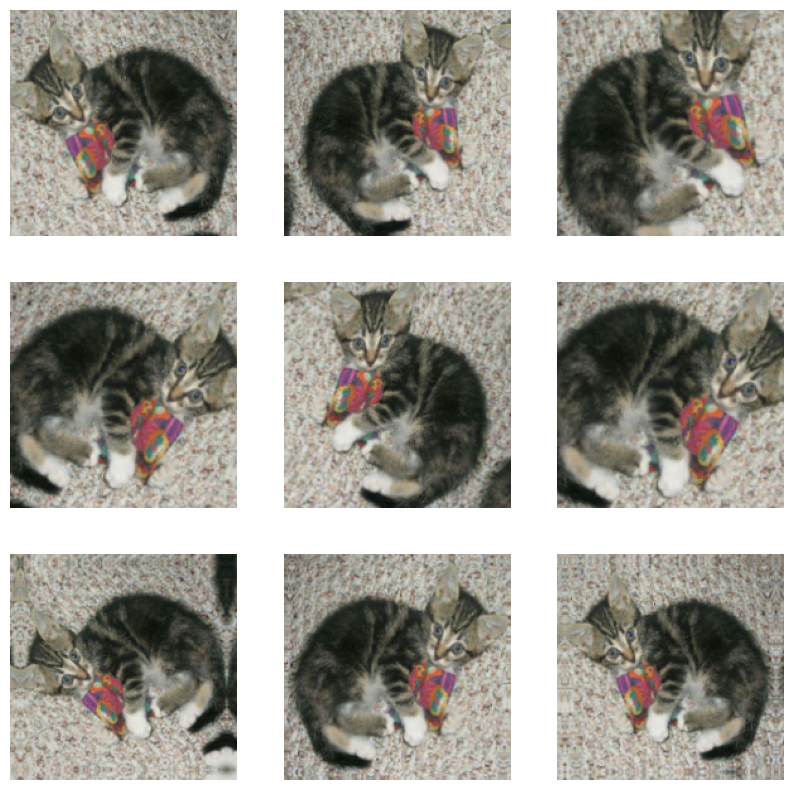

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
   for i in range(9):
      augmented_images = data_augmentation(images)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[0].numpy().astype("uint8"))
      plt.axis("off")

Model - 2 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.3

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Model 2: Training

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model2.keras",
            save_best_only= True,
            monitor= "val_loss")

# Fitting the Model

Model_2 = model.fit(
          train_dataset,
          epochs=30,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/30
32/32 [==============================] - 11s 284ms/step - loss: 0.6971 - accuracy: 0.4920 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/30
32/32 [==============================] - 9s 284ms/step - loss: 0.6938 - accuracy: 0.5250 - val_loss: 0.6918 - val_accuracy: 0.5060
Epoch 3/30
32/32 [==============================] - 9s 280ms/step - loss: 0.6972 - accuracy: 0.5240 - val_loss: 0.6835 - val_accuracy: 0.5500
Epoch 4/30
32/32 [==============================] - 9s 283ms/step - loss: 0.6853 - accuracy: 0.5460 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 5/30
32/32 [==============================] - 9s 282ms/step - loss: 0.6784 - accuracy: 0.5920 - val_loss: 0.6594 - val_accuracy: 0.6040
Epoch 6/30
32/32 [==============================] - 9s 282ms/step - loss: 0.6481 - accuracy: 0.6270 - val_loss: 0.6728 - val_accuracy: 0.5760
Epoch 7/30
32/32 [==============================] - 9s 281ms/step - loss: 0.6706 - accuracy: 0.5810 - val_loss: 0.6522 - val_accuracy: 0.6080
Epoch

Visualizing the Training and Validation Accuracy/Loss of Model 2

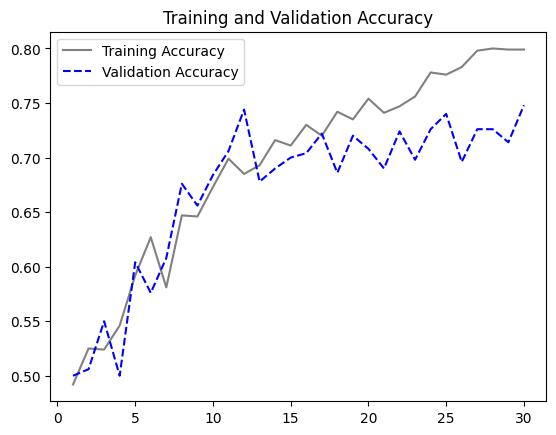

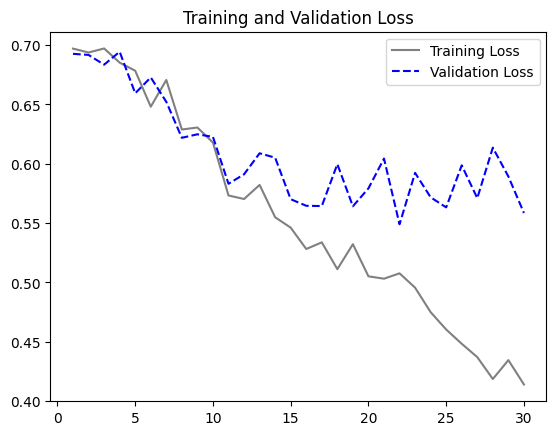

In [ ]:
accuracy = Model_2.history["accuracy"]
val_accuracy = Model_2.history["val_accuracy"]
loss = Model_2.history["loss"]
val_loss = Model_2.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating the performance of Model 2 on the test set

In [ ]:
test_model = keras.models.load_model("model2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")


16/16 [==============================] - 1s 54ms/step - loss: 0.5672 - accuracy: 0.7200
Loss: 0.567
Accuracy: 0.720


Comparing the Model 1 and Model 2 : we can clearly see that the accuracy rate of model 2 is higher than model 1

Model - 3 MaxPooling Operation with Increase in filters from 32 to 512 in 6 Input Layers with the use of Augmented Images and Dropout rate of 0.3

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Summary

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

Model 3 Training

In [ ]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ["accuracy"])


# Saving the results of the model
callbacks = ModelCheckpoint(
            filepath= "model3.keras",
            save_best_only= True,
            monitor= "val_loss")


# Fitting the model
Model_3 = model.fit(
          train_dataset,
          epochs=30,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/30
32/32 [==============================] - 11s 283ms/step - loss: 0.6980 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/30
32/32 [==============================] - 9s 273ms/step - loss: 0.6918 - accuracy: 0.5160 - val_loss: 0.7581 - val_accuracy: 0.5000
Epoch 3/30
32/32 [==============================] - 9s 278ms/step - loss: 0.6942 - accuracy: 0.5160 - val_loss: 0.6925 - val_accuracy: 0.5040
Epoch 4/30
32/32 [==============================] - 9s 274ms/step - loss: 0.6902 - accuracy: 0.5060 - val_loss: 0.6898 - val_accuracy: 0.5120
Epoch 5/30
32/32 [==============================] - 9s 273ms/step - loss: 0.6875 - accuracy: 0.5310 - val_loss: 0.6888 - val_accuracy: 0.5240
Epoch 6/30
32/32 [==============================] - 9s 275ms/step - loss: 0.6806 - accuracy: 0.5900 - val_loss: 0.6719 - val_accuracy: 0.6020
Epoch 7/30
32/32 [==============================] - 9s 271ms/step - loss: 0.6667 - accuracy: 0.5940 - val_loss: 0.8935 - val_accuracy: 0.5540
Epoch

Visualizing the Training and Validation Accuracy/Loss of Model 3

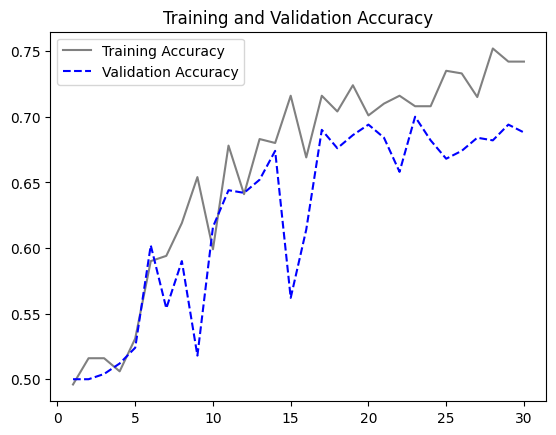

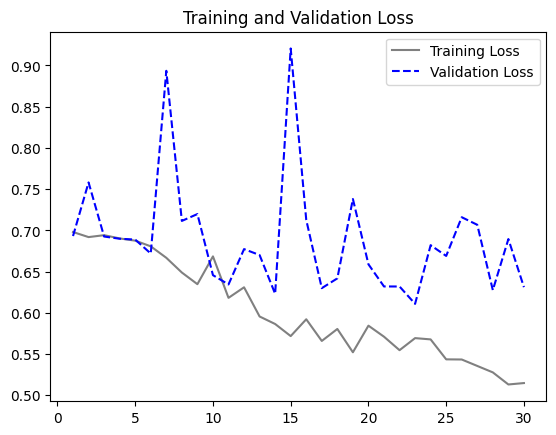

In [ ]:
accuracy = Model_3.history["accuracy"]
val_accuracy = Model_3.history["val_accuracy"]
loss = Model_3.history["loss"]
val_loss = Model_3.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating the performance of Model 3 on the test set

In [ ]:
test_model = keras.models.load_model("model3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")


16/16 [==============================] - 1s 54ms/step - loss: 0.6156 - accuracy: 0.6740
Loss: 0.616
Accuracy: 0.674


Model - 4 MaxPooling Operation with Increase in filters from 64 to 1024 in 5 Input Layers with the use of Augmented Images and Dropout rate of 0.5

In [ ]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Summary

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 89, 89, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 87, 87, 128)       73856     
                                                           

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model4.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting the Model

Model_4 = model.fit(
          train_dataset,
          epochs=30,
          validation_data= validation_dataset,
          callbacks= callbacks)


Epoch 1/30
32/32 [==============================] - 30s 903ms/step - loss: 0.7050 - accuracy: 0.5030 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/30
32/32 [==============================] - 28s 888ms/step - loss: 0.6937 - accuracy: 0.4950 - val_loss: 0.6922 - val_accuracy: 0.5180
Epoch 3/30
32/32 [==============================] - 28s 879ms/step - loss: 0.6957 - accuracy: 0.5410 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 4/30
32/32 [==============================] - 28s 878ms/step - loss: 0.6940 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 5/30
32/32 [==============================] - 28s 886ms/step - loss: 0.6931 - accuracy: 0.5390 - val_loss: 0.6894 - val_accuracy: 0.5120
Epoch 6/30
32/32 [==============================] - 28s 878ms/step - loss: 0.6823 - accuracy: 0.5650 - val_loss: 0.6980 - val_accuracy: 0.5000
Epoch 7/30
32/32 [==============================] - 28s 875ms/step - loss: 0.6868 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5040

Visualizing the Training and Validation Accuracy/Loss

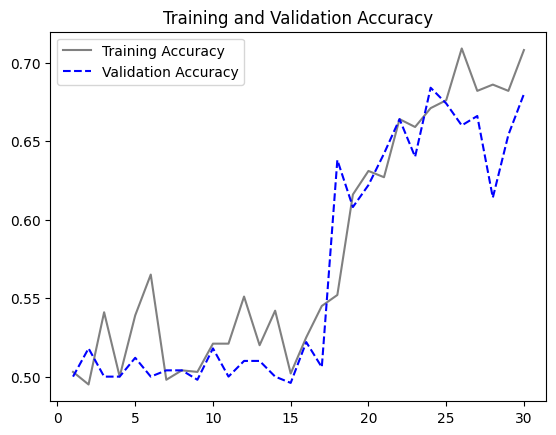

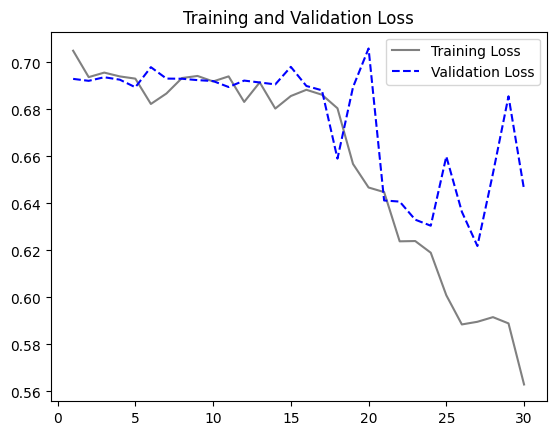

In [ ]:
accuracy = Model_4.history["accuracy"]
val_accuracy = Model_4.history["val_accuracy"]
loss = Model_4.history["loss"]
val_loss = Model_4.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating the performance of Model 4 on the test set

In [ ]:
test_model = keras.models.load_model("model4.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

16/16 [==============================] - 2s 127ms/step - loss: 0.6287 - accuracy: 0.6480
Loss: 0.629
Accuracy: 0.648




Summary for Question 1: We tried to build 4 models with the training sample being 1000. If we compare the loss and Accuracy of these models

Model 1: filters from 32 to 256, 5 Input Layers

Model 2: filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.3

Model 3: filters from 32 to 512, 6 Input Layers, Augmented Images and Dropout rate of 0.3

Model 4: filters from 64 to 1024, 5 Input Layers, Augmented Images and Dropout rate of 0.5


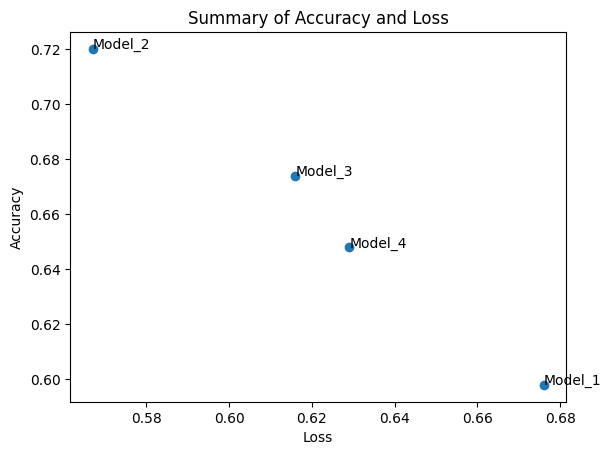

In [ ]:
Model_1 = (0.676, 0.598)
Model_2 = (0.567, 0.720)
Model_3 = (0.616,0.674)
Model_4 = (0.629, 0.648)

Models = ("Model_1","Model_2","Model_3","Model_4")
Loss = (Model_1[0],Model_2[0],Model_3[0],Model_4[0])
Accuracy = (Model_1[1],Model_2[1],Model_3[1],Model_4[1])

fig, ax = plt.subplots()
ax.scatter(Loss,Accuracy)
for i, txt in enumerate(Models):
    ax.annotate(txt, (Loss[i],Accuracy[i] ))
plt.title("Summary of Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")

plt.show()

Conclusions: From the above, we can conclude that Model 2 is the best among all with higher accuracy and minimum loss. Notably, Model 1 has the highest loss.

Recommendation: Model 2 is best performing model i.e. with filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.3

**2.Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?**

Considering training sample, train=1500, validation = 500, test = 500


In [ ]:
import os, shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

make_subset("train", start_index=0, end_index=750)
make_subset("validation", start_index=750, end_index=1000)
make_subset("test", start_index=1000, end_index=1250)


Data Pre-Processing

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


Viewing the size of the images

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Viewing the size of the images

In [ ]:
data_augmentation_1 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25)
    ]
)

Model - 5 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.3 (Training Sample - 2000)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_1(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

Model 5: Training

In [ ]:
# Compiling the model

model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath = "model5.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Fitting the model

Model_5 = model.fit(
          train_dataset,
          epochs=30,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/30
47/47 [==============================] - 14s 267ms/step - loss: 0.6988 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/30
47/47 [==============================] - 12s 265ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/30
47/47 [==============================] - 12s 265ms/step - loss: 0.6905 - accuracy: 0.5307 - val_loss: 0.6923 - val_accuracy: 0.5420
Epoch 4/30
47/47 [==============================] - 12s 264ms/step - loss: 0.6929 - accuracy: 0.5147 - val_loss: 0.6859 - val_accuracy: 0.5000
Epoch 5/30
47/47 [==============================] - 12s 262ms/step - loss: 0.6899 - accuracy: 0.5267 - val_loss: 0.6881 - val_accuracy: 0.4980
Epoch 6/30
47/47 [==============================] - 13s 267ms/step - loss: 0.6865 - accuracy: 0.5233 - val_loss: 0.6726 - val_accuracy: 0.5820
Epoch 7/30
47/47 [==============================] - 13s 266ms/step - loss: 0.6778 - accuracy: 0.5740 - val_loss: 0.6486 - val_accuracy: 0.6620

Visualizing the Training and Validation Accuracy/Loss

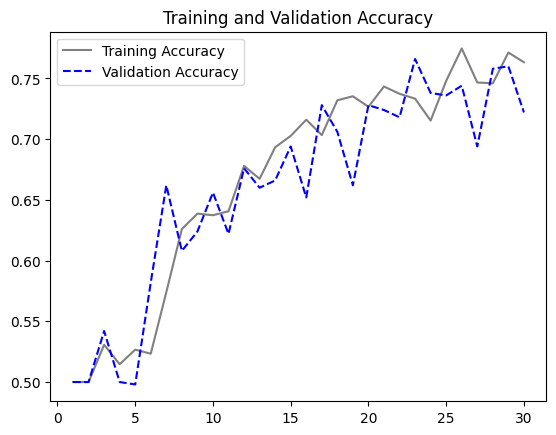

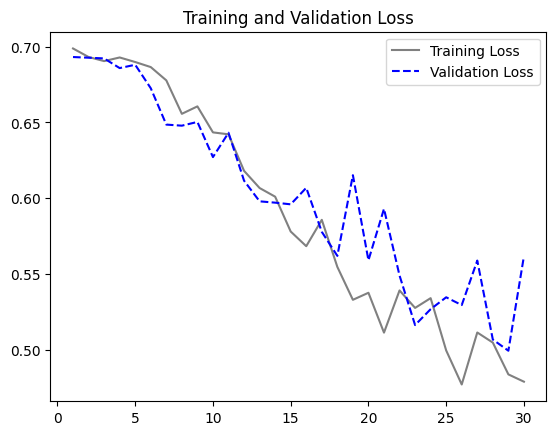

In [ ]:
accuracy = Model_5.history["accuracy"]
val_accuracy = Model_5.history["val_accuracy"]
loss = Model_5.history["loss"]
val_loss = Model_5.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating the performance of Model 5 on the test set

In [ ]:
test_model = keras.models.load_model("model5.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

16/16 [==============================] - 1s 57ms/step - loss: 0.4784 - accuracy: 0.7640
Loss: 0.478
Accuracy: 0.764


Summary: Model 2 built with 1000 training samples resulted in 72% accuracy, whereas the same model with an increase in training samples to 1500 spiked the accuracy to 76.4%

Model - 6 Strides Operation with Padding being "Same" with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.3 (Training Sample - 1500)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_1(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 90, 90, 32)        896       
                                                                 
 conv2d_27 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 conv2d_28 (Conv2D)          (None, 23, 23, 128)       73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 12, 12, 256)       2951

Model 6: Training

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model6.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting the Model

Model_6 = model.fit(
          train_dataset,
          epochs=30,
          validation_data= validation_dataset,
          callbacks= callbacks)


Epoch 1/30
47/47 [==============================] - 5s 70ms/step - loss: 0.6959 - accuracy: 0.4893 - val_loss: 0.6931 - val_accuracy: 0.5340
Epoch 2/30
47/47 [==============================] - 3s 68ms/step - loss: 0.6936 - accuracy: 0.4973 - val_loss: 0.6925 - val_accuracy: 0.5440
Epoch 3/30
47/47 [==============================] - 3s 67ms/step - loss: 0.6944 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/30
47/47 [==============================] - 3s 66ms/step - loss: 0.6935 - accuracy: 0.4813 - val_loss: 0.6928 - val_accuracy: 0.4960
Epoch 5/30
47/47 [==============================] - 3s 65ms/step - loss: 0.6928 - accuracy: 0.4960 - val_loss: 0.6930 - val_accuracy: 0.5400
Epoch 6/30
47/47 [==============================] - 3s 66ms/step - loss: 0.6942 - accuracy: 0.5087 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/30
47/47 [==============================] - 3s 65ms/step - loss: 0.6932 - accuracy: 0.4947 - val_loss: 0.6930 - val_accuracy: 0.5160
Epoch 8/30
47

Visualizing the Training and Validation Accuracy/Loss

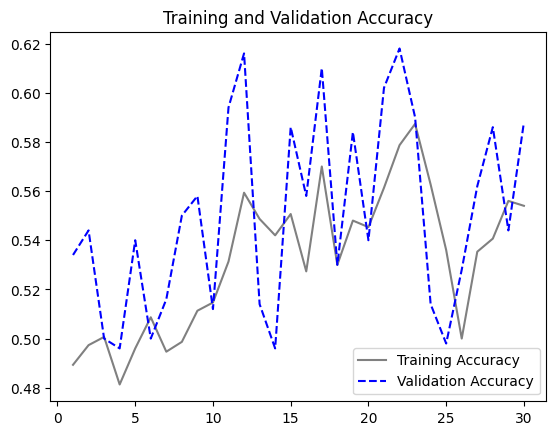

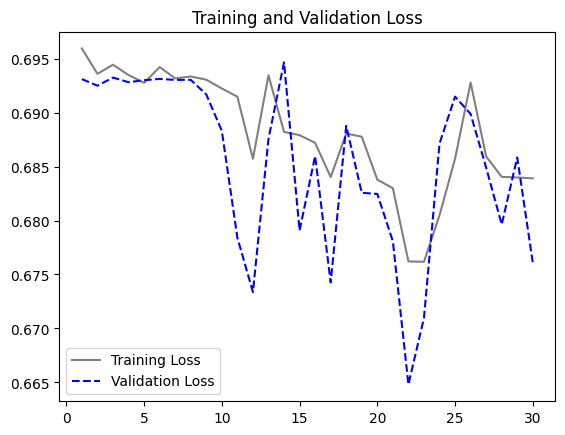

In [ ]:
accuracy = Model_6.history["accuracy"]
val_accuracy = Model_6.history["val_accuracy"]
loss = Model_6.history["loss"]
val_loss = Model_6.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating the performance of Model 6 on the test set

In [ ]:
test_model = keras.models.load_model("model6.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

16/16 [==============================] - 1s 18ms/step - loss: 0.6675 - accuracy: 0.6100
Loss: 0.667
Accuracy: 0.610


Summary for Question 2: We tried to build 2 more models with training sample 1500.

Model 2: filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.3, training size 1000

Model 5: filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.3, training size 1500

Model 6: filters from 32 to 256, 5 Input Layers, Augmented Images and Droput rate of 0.3, training size 1500, Padding being same

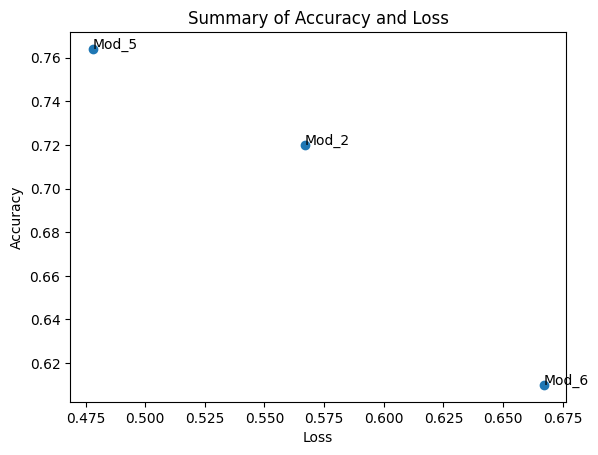

In [ ]:
Model_2 = (0.567, 0.720)
Model_5 = (0.478,0.764)
Model_6 = (0.667,0.610)

Models_2 = ("Mod_2","Mod_5","Mod_6")
Loss_2 = (Model_2[0],Model_5[0],Model_6[0])
Accuracy_2 = (Model_2[1],Model_5[1],Model_6[1])

fig, ax = plt.subplots()
ax.scatter(Loss_2,Accuracy_2)
for i, txt in enumerate(Models_2):
    ax.annotate(txt, (Loss_2[i],Accuracy_2[i] ))
plt.title("Summary of Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")

plt.show()

Comparing the performance of the models, it was observed that utilizing strides with padding did not significantly benefit the model. Model 5, which incorporated a Max Pooling Layer, exhibited higher accuracy compared to the Strides model. Furthermore, by optimizing the network and increasing the training dataset from 1000 to 1500 samples, an enhanced accuracy of 76.4% was achieved.

To address the second query, we plotted the performance of Model 5 and Model 6, allowing for a visual comparison. The graphs clearly illustrate that Model 5 achieved the highest accuracy among all the models, reaching 76.4%, with the lowest loss of 47.8%. The augmentation of the training samples to 1500 and the introduction of diverse augmented images notably contributed to the improved performance of the model.

**3.Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.**

Increasing the sample size to 1500 and 2000 for better performance

In [ ]:
import os, shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1250)
make_subset("test", start_index=1250, end_index=1500)

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
data_augmentation_2 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25)
    ]
)


Model - 7 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.3 (Training Sample - 2000)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_2(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model7.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting the Model

Model_7 = model.fit(
          train_dataset,
          epochs=30,
          validation_data= validation_dataset,
          callbacks= callbacks)


Epoch 1/30
63/63 [==============================] - 18s 270ms/step - loss: 0.6948 - accuracy: 0.5195 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 17s 276ms/step - loss: 0.6941 - accuracy: 0.4765 - val_loss: 0.6928 - val_accuracy: 0.5670
Epoch 3/30
63/63 [==============================] - 17s 265ms/step - loss: 0.6924 - accuracy: 0.5055 - val_loss: 0.6827 - val_accuracy: 0.5000
Epoch 4/30
63/63 [==============================] - 17s 267ms/step - loss: 0.6903 - accuracy: 0.5260 - val_loss: 0.6919 - val_accuracy: 0.5010
Epoch 5/30
63/63 [==============================] - 17s 267ms/step - loss: 0.6936 - accuracy: 0.5105 - val_loss: 0.6890 - val_accuracy: 0.5280
Epoch 6/30
63/63 [==============================] - 17s 267ms/step - loss: 0.6889 - accuracy: 0.5245 - val_loss: 0.6809 - val_accuracy: 0.5570
Epoch 7/30
63/63 [==============================] - 17s 268ms/step - loss: 0.6777 - accuracy: 0.5610 - val_loss: 0.6805 - val_accuracy: 0.5510

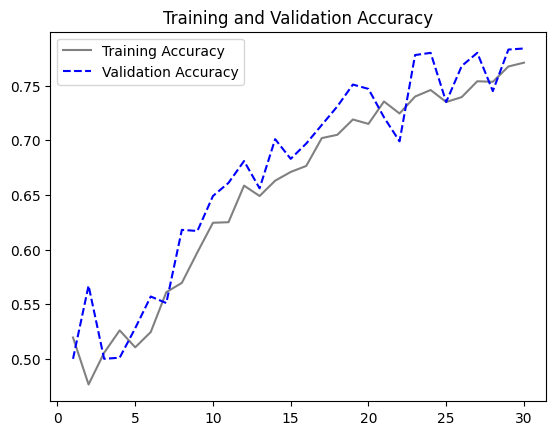

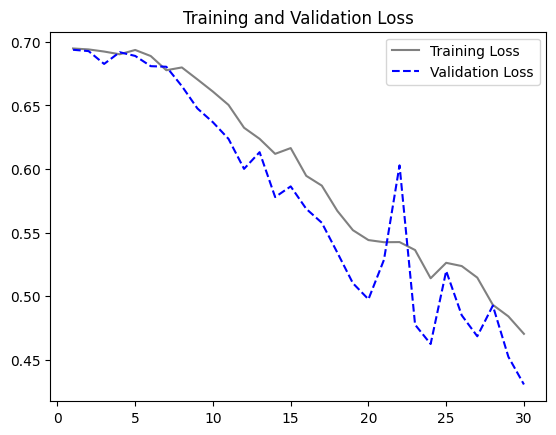

In [ ]:
accuracy = Model_7.history["accuracy"]
val_accuracy = Model_7.history["val_accuracy"]

loss = Model_7.history["loss"]
val_loss = Model_7.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("model7.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 56ms/step - loss: 0.4758 - accuracy: 0.7650
Loss: 0.476
Accuracy: 0.765


In the previous Model 6, we attempted to replace the conventional max pooling operation with strides, but the results were not as promising as expected. In Model 7, we reverted to using max pooling only. Therefore, we are now exploring a hybrid approach that combines both max pooling and strides to evaluate the performance of this new model.

Max pooling is a downsampling operation that reduces the spatial dimensions of the feature map, aiming to capture the most prominent features while discarding less relevant information. On the other hand, strides determine the step rate of the sliding window used to extract and learn features from the data. This hybrid approach aims to leverage the advantages of both techniques, potentially enhancing the model's ability to capture intricate patterns and features while maintaining computational efficiency.

Model - 8 MaxPooling + Strides of Step-Size 2 Operation with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.3 (Training Sample - 2000)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_2(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2,strides=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model8.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting the Model

Model_8 = model.fit(
          train_dataset,
          epochs=30,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/30
63/63 [==============================] - 19s 281ms/step - loss: 0.6933 - accuracy: 0.5205 - val_loss: 0.6787 - val_accuracy: 0.5690
Epoch 2/30
63/63 [==============================] - 17s 276ms/step - loss: 0.6890 - accuracy: 0.5295 - val_loss: 0.6846 - val_accuracy: 0.5110
Epoch 3/30
63/63 [==============================] - 17s 271ms/step - loss: 0.6816 - accuracy: 0.5470 - val_loss: 0.6763 - val_accuracy: 0.5510
Epoch 4/30
63/63 [==============================] - 17s 272ms/step - loss: 0.6856 - accuracy: 0.5430 - val_loss: 0.6559 - val_accuracy: 0.6160
Epoch 5/30
63/63 [==============================] - 17s 267ms/step - loss: 0.6780 - accuracy: 0.5670 - val_loss: 0.6681 - val_accuracy: 0.6180
Epoch 6/30
63/63 [==============================] - 17s 266ms/step - loss: 0.6791 - accuracy: 0.5690 - val_loss: 0.6495 - val_accuracy: 0.6160
Epoch 7/30
63/63 [==============================] - 17s 266ms/step - loss: 0.6522 - accuracy: 0.6235 - val_loss: 0.6323 - val_accuracy: 0.6440

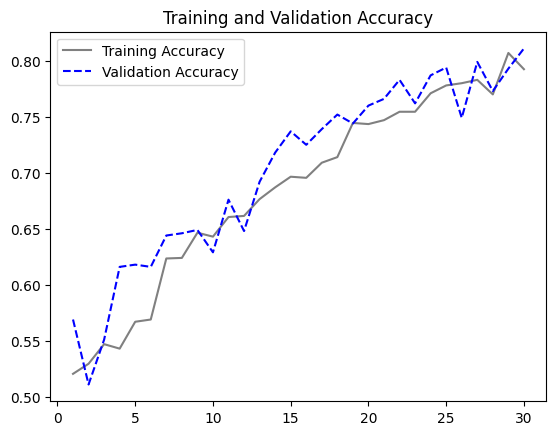

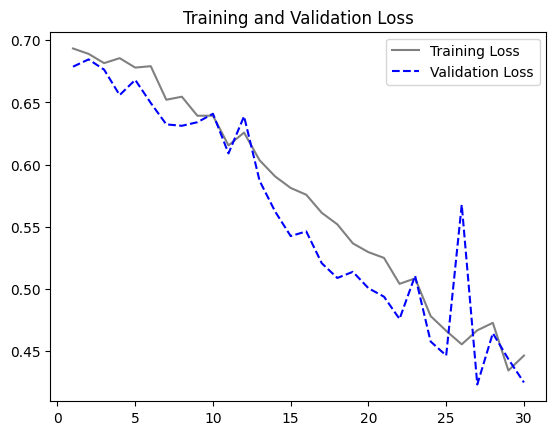

In [ ]:
accuracy = Model_8.history["accuracy"]
val_accuracy = Model_8.history["val_accuracy"]
loss = Model_8.history["loss"]
val_loss = Model_8.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("model8.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")


32/32 [==============================] - 2s 55ms/step - loss: 0.4544 - accuracy: 0.7790
Loss: 0.454
Accuracy: 0.779


Model - 9 MaxPooling + Strides of Step-Size 2 with Padding turned on Operation with Increase in filters from 32 to 512 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.3 (Training Sample - 2000)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_2(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2,strides=2, padding="same")(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model9.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting the Model

Model_9 = model.fit(
          train_dataset,
          epochs=30,
          validation_data= validation_dataset,
          callbacks= callbacks)


Epoch 1/30
63/63 [==============================] - 20s 300ms/step - loss: 0.6923 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 19s 298ms/step - loss: 0.6937 - accuracy: 0.4920 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 19s 298ms/step - loss: 0.6933 - accuracy: 0.4870 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/30
63/63 [==============================] - 19s 295ms/step - loss: 0.6923 - accuracy: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/30
63/63 [==============================] - 19s 299ms/step - loss: 0.6934 - accuracy: 0.5030 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/30
63/63 [==============================] - 19s 300ms/step - loss: 0.6932 - accuracy: 0.4820 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/30
63/63 [==============================] - 19s 298ms/step - loss: 0.6932 - accuracy: 0.4820 - val_loss: 0.6931 - val_accuracy: 0.5000

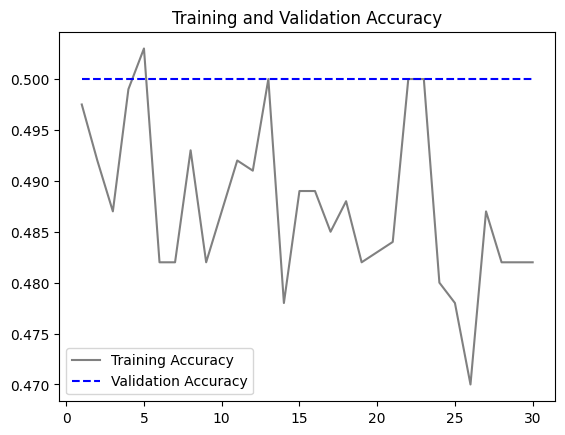

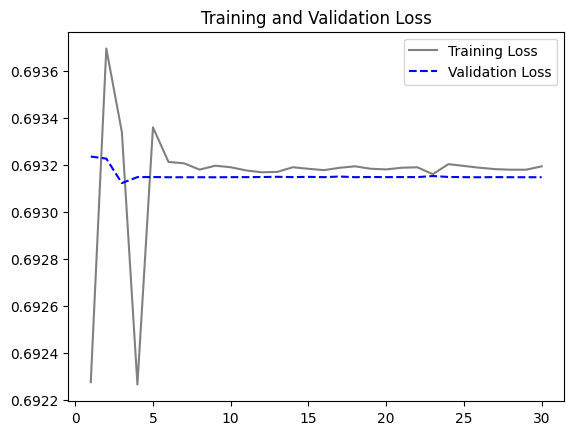

In [ ]:
accuracy = Model_9.history["accuracy"]
val_accuracy = Model_9.history["val_accuracy"]
loss = Model_9.history["loss"]
val_loss = Model_9.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("model9.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 59ms/step - loss: 0.6931 - accuracy: 0.5000
Loss: 0.693
Accuracy: 0.500


Let's see which of the models have the best performance when the training sample size is set to 2000. Note: Models 8 and 9 were trained differently, with strides being used alongside max pooling and strides being used with max pooling and padding turned on.

Model 6: Strides operation with padding set to "Same," filters from 32 to 512, 5 input layers, dropout rate of 0.3, training sample size of 1500.

Model 7: MaxPooling operation, filters from 32 to 512, 5 input layers, dropout rate of 0.3, training sample size of 2000.

Model 8: MaxPooling + strides with a step size of 2, filters from 32 to 512, 5 input layers, dropout rate of 0.3, training sample size of 2000.

Model 9: MaxPooling + strides with a step size of 2 and padding turned on, filters from 32 to 512, 5 input layers, dropout rate of 0.3, training sample size of 2000.

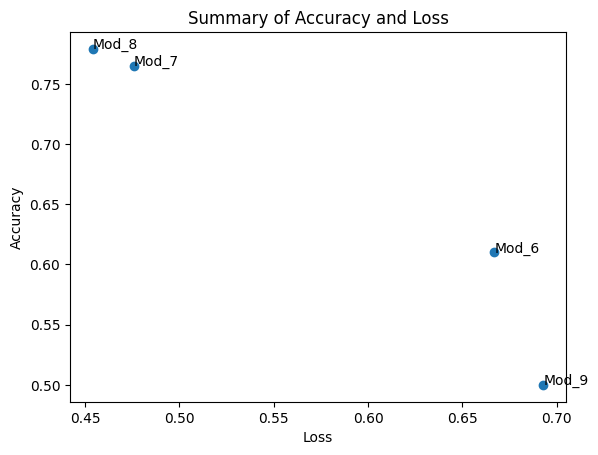

In [ ]:
Model_6 = (0.667,0.610)
Model_7 = (0.476,0.765)
Model_8 = (0.454,0.779)
Model_9 = (0.693,0.500)

Models_3 = ("Mod_6","Mod_7","Mod_8","Mod_9")
Loss_3 = (Model_6[0],Model_7[0],Model_8[0],Model_9[0])
Accuracy_3 = (Model_6[1],Model_7[1],Model_8[1],Model_9[1])

fig, ax = plt.subplots()
ax.scatter(Loss_3,Accuracy_3)
for i, txt in enumerate(Models_3):
    ax.annotate(txt, (Loss_3[i],Accuracy_3[i] ))
plt.title("Summary of Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")


plt.show()

We can clearly see that the model 8 achieved the highest accuracy of 77.9% and the lowest loss of 45.4% among all the models.

Training Sample 3000, Validation 500, Test 500

In [ ]:
import os, shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=1750)
make_subset("test", start_index=1750, end_index=2000)


In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
data_augmentation_3 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25)
    ]
)

Model - 10 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers with the data being used from the Augmented Images and a droput rate of 0.3 (Training Sample - 3000)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_3(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_46 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "model10.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting the Model

Model_10 = model.fit(
          train_dataset,
          epochs=30,
          validation_data= validation_dataset,
          callbacks= callbacks)


Epoch 1/30
94/94 [==============================] - 25s 255ms/step - loss: 0.6939 - accuracy: 0.4933 - val_loss: 0.6898 - val_accuracy: 0.5800
Epoch 2/30
94/94 [==============================] - 24s 251ms/step - loss: 0.6926 - accuracy: 0.5213 - val_loss: 0.6909 - val_accuracy: 0.5160
Epoch 3/30
94/94 [==============================] - 24s 252ms/step - loss: 0.6857 - accuracy: 0.5573 - val_loss: 0.6894 - val_accuracy: 0.6000
Epoch 4/30
94/94 [==============================] - 24s 254ms/step - loss: 0.6817 - accuracy: 0.5650 - val_loss: 0.6841 - val_accuracy: 0.5840
Epoch 5/30
94/94 [==============================] - 24s 253ms/step - loss: 0.6619 - accuracy: 0.6150 - val_loss: 0.6872 - val_accuracy: 0.6200
Epoch 6/30
94/94 [==============================] - 24s 254ms/step - loss: 0.6400 - accuracy: 0.6443 - val_loss: 0.6486 - val_accuracy: 0.6440
Epoch 7/30
94/94 [==============================] - 24s 255ms/step - loss: 0.6244 - accuracy: 0.6623 - val_loss: 0.6703 - val_accuracy: 0.5980

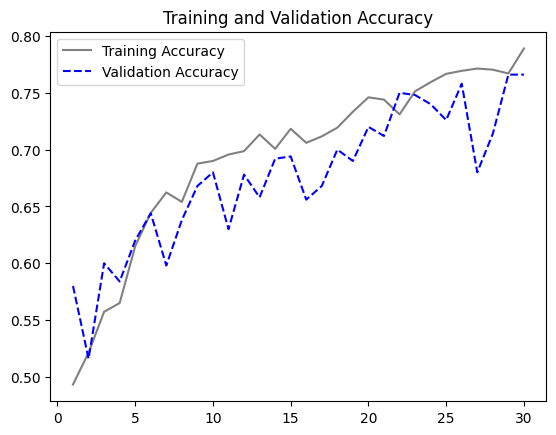

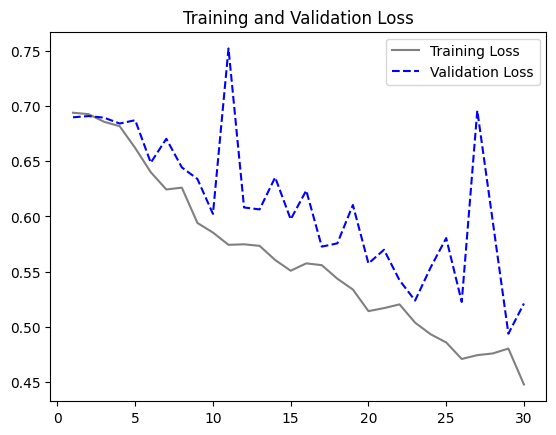

In [ ]:
accuracy = Model_10.history["accuracy"]
val_accuracy = Model_10.history["val_accuracy"]
loss = Model_10.history["loss"]
val_loss = Model_10.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("model10.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

16/16 [==============================] - 1s 52ms/step - loss: 0.4886 - accuracy: 0.7500
Loss: 0.489
Accuracy: 0.750


In summary for Question 3, we constructed four models, three of which were trained with a sample size of 2000. The top-performing model achieved an accuracy of 77.9%. Notably, when we expanded the training sample to 3000, the accuracy decreased to 75.0%. Consequently, we deduce that increasing the training sample size to 3000 substantially decreased the model's performance.

Regarding the plausible reason for the validation loss being higher than the training loss, it is likely influenced by the adopted split strategy. In this case, the training sample is nearly 3000, while the validation and test sets remain fixed at 500 each. Additionally, it is essential to acknowledge that during training, regularizations such as dropout or L1 and L2 regularizers play a significant role, contributing to the computation of the training loss. Conversely, during the validation or test phase, these regularizers are disabled, potentially leading to a lower loss compared to the training loss.

**4.Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.**

Leveraging a Pre-Trained Model - VGG16

VGG - Model 1 (1000 Training Samples)

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
#extracting VGG 16 features and Labels
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 264ms/step


In [ ]:
train_features.shape

(3000, 5, 5, 512)

VGG - Model 1 Dense Layer with 256 Nodes and Droput Rate of 0.3 and optimizer being rmsprop with the Original Images

In [ ]:
# Defining and Training the densely connected classifier
# The last dense stacked layer and the classifier
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)


# Compiling the Model

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath="vgg_model1.keras",
            save_best_only=True,
            monitor="val_loss")


# Fitting the model

VGG_Model_1 = model.fit(
              train_features, train_labels,
              epochs=30,
              validation_data=(val_features, val_labels),
              callbacks=callbacks)

Epoch 1/30
94/94 [==============================] - 1s 11ms/step - loss: 16.4197 - accuracy: 0.9320 - val_loss: 11.8097 - val_accuracy: 0.9560
Epoch 2/30
94/94 [==============================] - 1s 10ms/step - loss: 2.4591 - accuracy: 0.9827 - val_loss: 4.8412 - val_accuracy: 0.9720
Epoch 3/30
94/94 [==============================] - 1s 9ms/step - loss: 1.6782 - accuracy: 0.9897 - val_loss: 6.2699 - val_accuracy: 0.9660
Epoch 4/30
94/94 [==============================] - 1s 9ms/step - loss: 1.0990 - accuracy: 0.9923 - val_loss: 6.7413 - val_accuracy: 0.9700
Epoch 5/30
94/94 [==============================] - 1s 9ms/step - loss: 0.4193 - accuracy: 0.9957 - val_loss: 6.1874 - val_accuracy: 0.9740
Epoch 6/30
94/94 [==============================] - 1s 9ms/step - loss: 0.5701 - accuracy: 0.9953 - val_loss: 12.8699 - val_accuracy: 0.9600
Epoch 7/30
94/94 [==============================] - 1s 9ms/step - loss: 0.3391 - accuracy: 0.9970 - val_loss: 10.1541 - val_accuracy: 0.9680
Epoch 8/30
94/

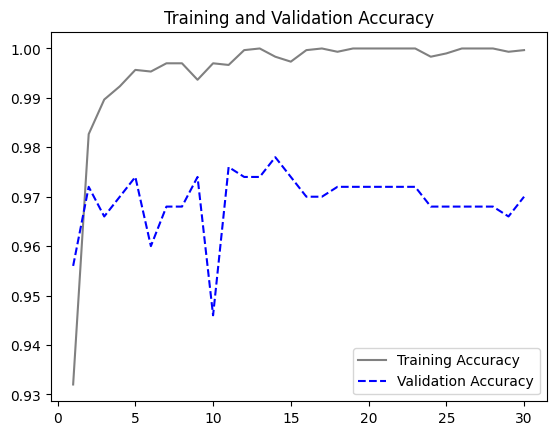

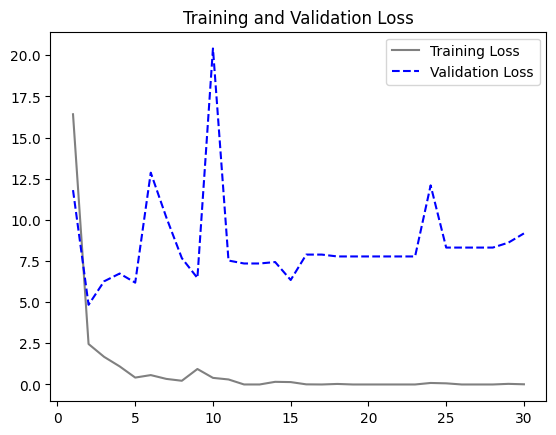

In [ ]:
import matplotlib.pyplot as plt

accuracy = VGG_Model_1.history["accuracy"]
val_accuracy = VGG_Model_1.history["val_accuracy"]
loss = VGG_Model_1.history["loss"]
val_loss = VGG_Model_1.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("vgg_model1.keras")
test_loss, test_acc = best_model.evaluate(test_features,test_labels)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

16/16 [==============================] - 0s 3ms/step - loss: 4.2060 - accuracy: 0.9780
Loss: 4.206
Accuracy: 0.978


VGG - Model 2 (1000 Training Samples)

In [ ]:
conv_base= keras.applications.vgg16.VGG16(
           weights="imagenet",
           include_top=False)

conv_base.trainable = False

We have configured the pre-trained model to retain its existing weights during training, only allowing the densely connected networks and the classifier to adjust their weights during the training process.

This approach helps prevent overfitting, as the pre-trained model remains unchanged, providing a stable foundation for the model. Moreover, when dealing with limited training data and constrained computational resources, freezing the pre-trained model can be particularly advantageous.

To illustrate the impact of this configuration, we can print the list of trainable weights both before and after freezing the pre-trained model.

In [ ]:
# Before Freezing
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
# After Freezing
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

VGG - Model 2 Dense Layer with 256 Nodes and Droput Rate of 0.3 and optimizer being rmsprop with the Augmented Images

In [ ]:
# Data Augmentation -Adding a data augmentation stage to provide augmented training samples and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Adding the Classifier and Dense Network
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)



In [ ]:
# Model compilation
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = [
    ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss"
    )
]

# Fitting the model

VGG_Model_2 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
32/32 [==============================] - 18s 535ms/step - loss: 6.2161 - accuracy: 0.5170 - val_loss: 0.9840 - val_accuracy: 0.5000
Epoch 2/30
32/32 [==============================] - 14s 441ms/step - loss: 3.8346 - accuracy: 0.5160 - val_loss: 3.2839 - val_accuracy: 0.5000
Epoch 3/30
32/32 [==============================] - 17s 543ms/step - loss: 3.3307 - accuracy: 0.4810 - val_loss: 0.7315 - val_accuracy: 0.5000
Epoch 4/30
32/32 [==============================] - 14s 453ms/step - loss: 2.5020 - accuracy: 0.5210 - val_loss: 0.8559 - val_accuracy: 0.5000
Epoch 5/30
32/32 [==============================] - 14s 454ms/step - loss: 2.1623 - accuracy: 0.4760 - val_loss: 0.8028 - val_accuracy: 0.5000
Epoch 6/30
32/32 [==============================] - 14s 455ms/step - loss: 1.6353 - accuracy: 0.4810 - val_loss: 1.7116 - val_accuracy: 0.5000
Epoch 7/30
32/32 [==============================] - 17s 529ms/step - loss: 1.3487 - accuracy: 0.4870 - val_loss: 0.7162 - val_accuracy: 0.5000

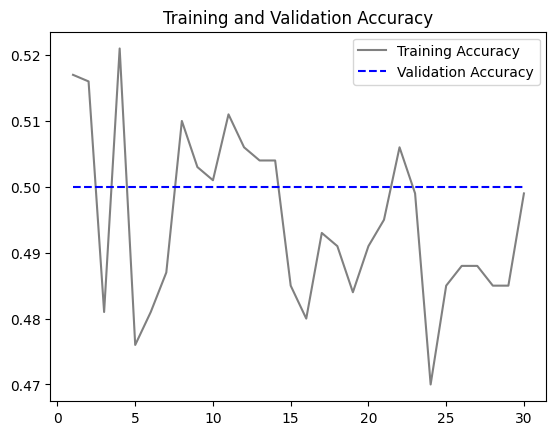

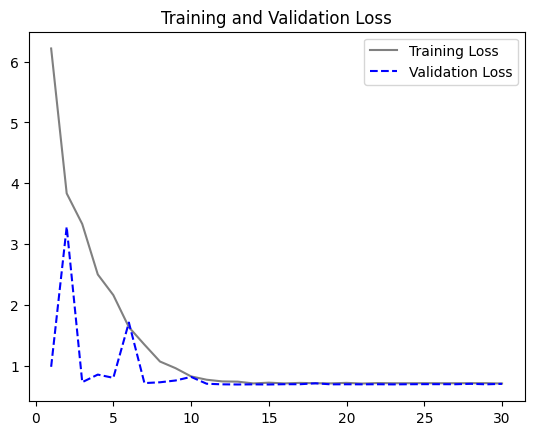

In [ ]:
import matplotlib.pyplot as plt

accuracy = VGG_Model_2.history["accuracy"]
val_accuracy = VGG_Model_2.history["val_accuracy"]
loss = VGG_Model_2.history["loss"]
val_loss = VGG_Model_2.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

16/16 [==============================] - 6s 375ms/step - loss: 0.7082 - accuracy: 0.5360
Loss: 0.708
Accuracy: 0.536


Fine Tuning the VGG_Model_2

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

It is crucial to understand that pre-trained networks are not solely utilized for singular image classification tasks; they are trained to handle diverse use cases and classifications. The initial layers of the network are adept at capturing general features, while the subsequent layers specialize in extracting features specific to the problem at hand. When we opt to freeze the initial layers, we effectively prevent overfitting, enabling the model to assimilate more intricate details pertaining to our specific classification task. This strategic approach encourages the model to focus on learning the nuanced aspects of the target classification problem.


In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath="fine_convnet_from_scratch.x",
            save_best_only=True,
            monitor="val_loss")

# Fitting the model

FineTuned_VGG_Model_2 = model.fit(
                        train_dataset,
                        epochs=30,
                        validation_data=validation_dataset,
                        callbacks=callbacks)

Epoch 1/30
32/32 [==============================] - 25s 750ms/step - loss: 0.6934 - accuracy: 0.5210 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 2/30
32/32 [==============================] - 23s 722ms/step - loss: 0.6932 - accuracy: 0.5230 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 3/30
32/32 [==============================] - 23s 722ms/step - loss: 0.6936 - accuracy: 0.5060 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 4/30
32/32 [==============================] - 24s 739ms/step - loss: 0.6935 - accuracy: 0.5170 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 5/30
32/32 [==============================] - 23s 723ms/step - loss: 0.6939 - accuracy: 0.4990 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 6/30
32/32 [==============================] - 21s 645ms/step - loss: 0.6925 - accuracy: 0.5040 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 7/30
32/32 [==============================] - 20s 642ms/step - loss: 0.6929 - accuracy: 0.5090 - val_loss: 0.6937 - val_accuracy: 0.5000

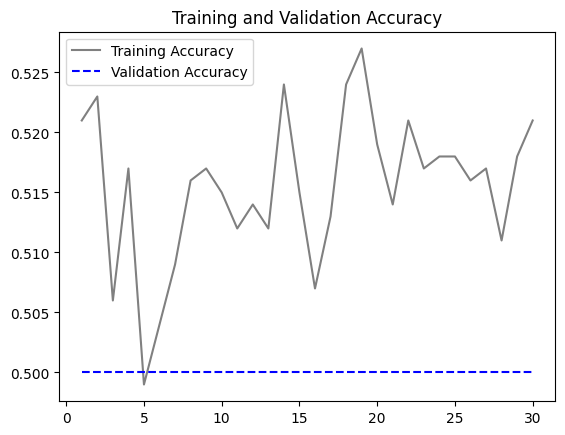

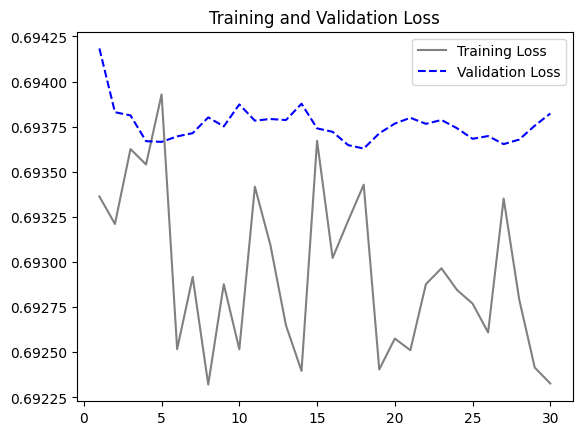

In [ ]:
import matplotlib.pyplot as plt

accuracy = FineTuned_VGG_Model_2.history["accuracy"]
val_accuracy = FineTuned_VGG_Model_2.history["val_accuracy"]
loss = FineTuned_VGG_Model_2.history["loss"]
val_loss = FineTuned_VGG_Model_2.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("fine_convnet_from_scratch.x")
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

16/16 [==============================] - 6s 371ms/step - loss: 0.7906 - accuracy: 0.3900
Loss: 0.791
Accuracy: 0.390


In the analysis of the two VGG16 models, we constructed three models utilizing the pre-trained network VGG16. Notably, we observed that preventing the pre-trained network from updating its weights during training and subsequently freezing the initial layers resulted in higher accuracy. Consequently, we aim to employ the same methodology in building two models using a training sample size of 2000.

VGG - Model 3 (3000 Training Samples)

In [ ]:
conv_base= keras.applications.vgg16.VGG16(
           weights="imagenet",
           include_top=False)

conv_base.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [ ]:
# Data Augmentation
data_augmentation_4 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25),
    ]
)

# Adding the Classifier and Dense Network
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_4(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath= "m3_convnet_from_scratch.x",
            save_best_only= True,
            monitor= "val_loss")

# Fitting the model

VGG_Model_3 = model.fit(
              train_dataset,
              epochs= 30,
              validation_data=validation_dataset,
              callbacks=callbacks)

Epoch 1/30
94/94 [==============================] - 47s 489ms/step - loss: 9.8418 - accuracy: 0.9193 - val_loss: 9.4048 - val_accuracy: 0.9600
Epoch 2/30
94/94 [==============================] - 45s 483ms/step - loss: 7.6537 - accuracy: 0.9403 - val_loss: 6.3159 - val_accuracy: 0.9600
Epoch 3/30
94/94 [==============================] - 47s 501ms/step - loss: 4.5282 - accuracy: 0.9547 - val_loss: 2.8349 - val_accuracy: 0.9740
Epoch 4/30
94/94 [==============================] - 44s 464ms/step - loss: 3.2417 - accuracy: 0.9530 - val_loss: 3.2305 - val_accuracy: 0.9720
Epoch 5/30
94/94 [==============================] - 46s 490ms/step - loss: 2.8089 - accuracy: 0.9553 - val_loss: 1.2659 - val_accuracy: 0.9760
Epoch 6/30
94/94 [==============================] - 44s 468ms/step - loss: 1.6658 - accuracy: 0.9630 - val_loss: 1.5560 - val_accuracy: 0.9660
Epoch 7/30
94/94 [==============================] - 46s 495ms/step - loss: 1.0650 - accuracy: 0.9683 - val_loss: 1.1985 - val_accuracy: 0.9760

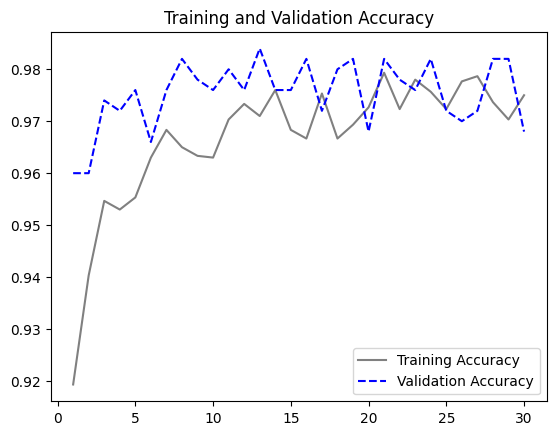

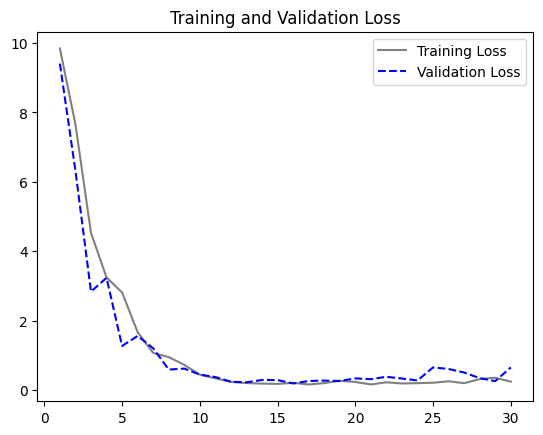

In [ ]:
import matplotlib.pyplot as plt

accuracy = VGG_Model_3.history["accuracy"]
val_accuracy = VGG_Model_3.history["val_accuracy"]
loss = VGG_Model_3.history["loss"]
val_loss = VGG_Model_3.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("m3_convnet_from_scratch.x")
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

16/16 [==============================] - 6s 379ms/step - loss: 0.1782 - accuracy: 0.9740
Loss: 0.178
Accuracy: 0.974


Fine Tunning VGG_Model_3 (Training Samples - 3000)

In our efforts to optimize VGG_Model3, we have chosen to freeze the initial four layers. This strategy aims to prevent the model from overfitting and allows it to concentrate solely on learning the distinctive features relevant to our particular classification task. Consequently, we have configured the pre-trained layers to remain unaltered during training while ensuring that the first four layers remain frozen. These optimizations are instrumental in enhancing the model's performance when dealing with a training sample size of 3000.

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
# Compiling the model

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

# Saving the results of the model

callbacks = ModelCheckpoint(
            filepath="fine_m3_convnet_from_scratch.x",
            save_best_only=True,
            monitor="val_loss")

# Fitting the model

FineTuned_VGG_Model_3 = model.fit(
                        train_dataset,
                        epochs=30,
                        validation_data=validation_dataset,
                        callbacks=callbacks)

Epoch 1/30
94/94 [==============================] - 65s 671ms/step - loss: 0.2473 - accuracy: 0.9757 - val_loss: 0.2908 - val_accuracy: 0.9820
Epoch 2/30
94/94 [==============================] - 60s 637ms/step - loss: 0.1149 - accuracy: 0.9840 - val_loss: 0.3192 - val_accuracy: 0.9820
Epoch 3/30
94/94 [==============================] - 60s 636ms/step - loss: 0.1325 - accuracy: 0.9823 - val_loss: 0.3669 - val_accuracy: 0.9740
Epoch 4/30
94/94 [==============================] - 61s 647ms/step - loss: 0.1272 - accuracy: 0.9820 - val_loss: 0.3737 - val_accuracy: 0.9720
Epoch 5/30
94/94 [==============================] - 60s 644ms/step - loss: 0.1475 - accuracy: 0.9823 - val_loss: 0.3525 - val_accuracy: 0.9740
Epoch 6/30
94/94 [==============================] - 61s 646ms/step - loss: 0.0992 - accuracy: 0.9853 - val_loss: 0.3987 - val_accuracy: 0.9700
Epoch 7/30
94/94 [==============================] - 63s 672ms/step - loss: 0.0851 - accuracy: 0.9857 - val_loss: 0.2026 - val_accuracy: 0.9800

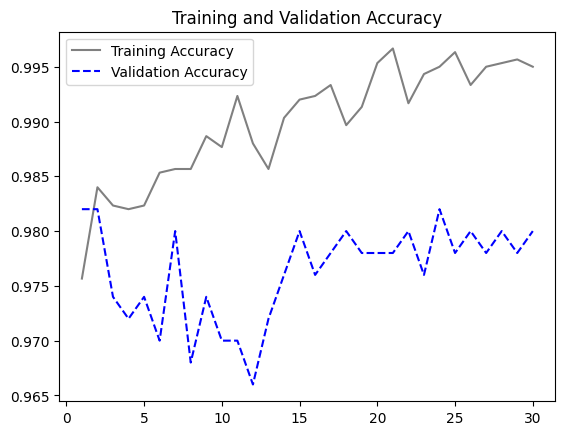

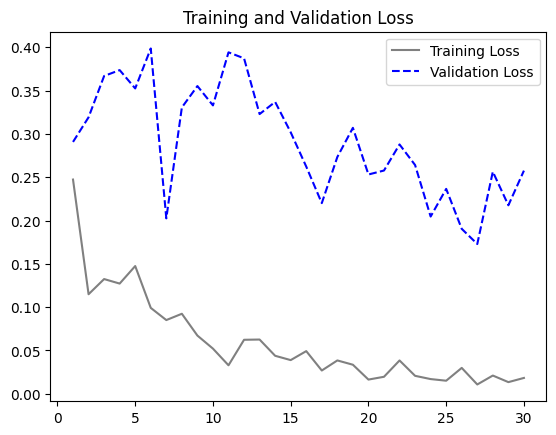

In [ ]:
import matplotlib.pyplot as plt

accuracy = FineTuned_VGG_Model_3.history["accuracy"]
val_accuracy = FineTuned_VGG_Model_3.history["val_accuracy"]
loss = FineTuned_VGG_Model_3.history["loss"]
val_loss = FineTuned_VGG_Model_3.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("fine_m3_convnet_from_scratch.x")
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Loss: {test_loss:.3f}")
print(f"Accuracy: {test_acc:.3f}")

16/16 [==============================] - 6s 373ms/step - loss: 0.1517 - accuracy: 0.9800
Loss: 0.152
Accuracy: 0.980


Having constructed a total of 15 models, including two fine-tuned versions, we aim to conduct a comparative analysis to identify the best-performing models in two categories: Scratch Models and Pre-Trained Models. Our immediate focus is to evaluate the best model developed from scratch. This evaluation involves comparing the loss and accuracy metrics across 10 models built with varying configurations and training sample sizes for classifying cats and dogs.

Model 1: Filters from 32 to 256, 5 Input Layers

Model 2: Filters from 32 to 256, 5 Input Layers, Augmented Images, Dropout rate of 0.5

Model 3: Filters from 32 to 512, 6 Input Layers, Augmented Images, Dropout rate of 0.5

Model 4: Filters from 64 to 1024, 5 Input Layers, Augmented Images, Dropout rate of 0.6

Model 5: Filters from 32 to 256, 5 Input Layers, Augmented Images, Dropout rate of 0.5, Training Size - 1500

Model 6: Filters from 32 to 256, 5 Input Layers, Augmented Images, Dropout rate of 0.5, Training Size - 1500, Padding set to 'Same'

Model 7: MaxPooling Operation, Filters from 32 to 512, 5 Input Layers, Augmented Images, Dropout rate of 0.5, Training Sample - 2000

Model 8: MaxPooling + Strides of Step-Size 2, Filters from 32 to 512, 5 Input Layers, Augmented Images, Dropout rate of 0.5, Training Sample - 2000

Model 9: MaxPooling + Strides of Step-Size 2 with Padding turned on, Filters from 32 to 512, 5 Input Layers, Augmented Images, Dropout rate of 0.5, Training Sample - 2000

Model 10: Filters from 32 to 512, 5 Input Layers, Augmented Images, Dropout rate of 0.5, Training Size - 3000

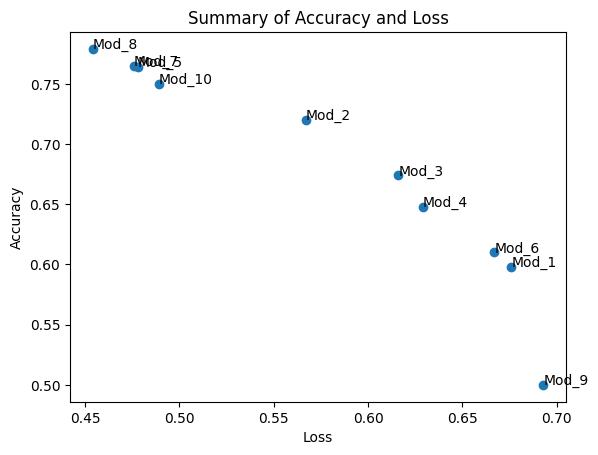

In [ ]:
# Scratch Models
Model_1 = (0.676, 0.598)
Model_2 = (0.567, 0.720)
Model_3 = (0.616,0.674)
Model_4 = (0.629, 0.648)
Model_5 = (0.478,0.764)
Model_6 = (0.667,0.610)
Model_7 = (0.476,0.765)
Model_8 = (0.454,0.779)
Model_9 = (0.693,0.500)
Model_10 = (0.489, 0.750)


Models_4 = ("Mod_1","Mod_2","Mod_3","Mod_4","Mod_5","Mod_6","Mod_7","Mod_8","Mod_9","Mod_10")
Loss_4 = (Model_1[0],Model_2[0],Model_3[0],Model_4[0],Model_5[0],Model_6[0],Model_7[0],Model_8[0],Model_9[0],Model_10[0])
Accuracy_4 = (Model_1[1],Model_2[1],Model_3[1],Model_4[1],Model_5[1],Model_6[1],Model_7[1],Model_8[1],Model_9[1],Model_10[1])

fig, ax = plt.subplots()
ax.scatter(Loss_4,Accuracy_4)
for i, txt in enumerate(Models_4):
    ax.annotate(txt, (Loss_4[i],Accuracy_4[i] ))
plt.title("Summary of Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")


plt.show()

Among the scratch models, Model_8 trained with 2000 samples emerged as the top-performing model, achieving an impressive 77.9% accuracy and a 45.4% loss on the test set.

Next, we built 5 models using the pre-trained VGG16 network. The first 3 models were trained with 1000 samples using RMSprop as the optimizer, while the remaining 2 models were trained with 3000 samples using Adam as the optimizer.

VGG Models:

  VGG 1: Filters from 32 to 256, 5 Input Layers

  VGG 2: Filters from 32 to 256, 5 Input Layers, Augmented Images, Dropout rate of 0.3

  VGG 3: Filters from 32 to 512, 6 Input Layers, Augmented Images, Dropout rate of 0.3

  VGG 4: VGG - Model 3 (3000 Training Samples)

  VGG 5: Fine-Tuning VGG_Model_3 (Training Samples - 3000)

In [ ]:
# Pre-Trained Models
VGG_Model_1 = (4.206,0.978)
VGG_Model_2 = (0.708,0.536)
FineTuned_VGG_Model_2 = (0.791,0.390)
VGG_Model_3 = (0.178,0.974)
FineTuned_VGG_Model_3 = (0.152,0.980)

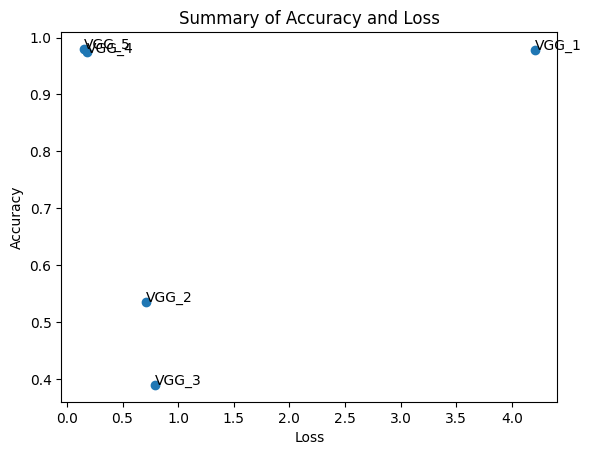

In [ ]:
import matplotlib.pyplot as plt

Models_5 = ("VGG_1","VGG_2","VGG_3","VGG_4","VGG_5")
Loss_5 = (VGG_Model_1[0],VGG_Model_2[0],FineTuned_VGG_Model_2[0],VGG_Model_3[0],FineTuned_VGG_Model_3[0])
Accuracy_5 = (VGG_Model_1[1],VGG_Model_2[1],FineTuned_VGG_Model_2[1],VGG_Model_3[1],FineTuned_VGG_Model_3[1])

fig, ax = plt.subplots()
ax.scatter(Loss_5,Accuracy_5)
for i, txt in enumerate(Models_5):
    ax.annotate(txt, (Loss_5[i],Accuracy_5[i] ))
plt.title("Summary of Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")


plt.show()

In the realm of pre-trained models, it was Model_5 (VGG_Model_3) and Model_4 (FineTuned_VGG_Model_3) that stood out as the top performers, boasting an impressive 98% accuracy and a mere 15% loss. These models were constructed with 3000 training samples respectively, and were optimized using the Adam optimizer with a learning rate of 0.000001.